In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ***Initial Data import: RNA-seq, HRD scores, BRCA annotations***

In [88]:
# Load the FPKM RNA-seq data
rnaseq_df = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('../data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')

In [89]:
print(f"Initial samples in RNA-seq data (n = {len(rnaseq_df.index)}) \n\nInitial samples in TCGA BRCA (n = {len(brca_df.index)})\n\nInitial samples in TCGA HRD (n = {len(hrd_df.index)})\n\n")

Initial samples in RNA-seq data (n = 1231) 

Initial samples in TCGA BRCA (n = 992)

Initial samples in TCGA HRD (n = 9604)




# ***Drop ambiguouse/ mislabled samples***

In [90]:
# Drop rows where event.BRCA1 is '1' and event.BRCA2 is 'Bi-allelic-undetermined' and where event.PALB2 is '2'
brca_filt = brca_df[(brca_df['event.BRCA1'] != '1') & (brca_df['event.BRCA2'] != 'Bi-allelic-undetermined') & (brca_df['event.PALB2'] != '2')]
brca_filt.shape

(984, 33)

# ***Merge metadata***

In [91]:
#merge metadata

metadata = pd.merge(hrd_df, brca_filt, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(859, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,0.041857,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,0.120368,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,0.604671,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,0.040404,0,0,0,0,0,LumA,0


# Keep Protein coding columns + extracting gene IDs
## filter only Primary Tumor Samples

In [92]:
rnaseq_df.shape

(1231, 60663)

In [93]:
#filt protein coding only
columns_to_keep = ['Case ID', 'Sample ID', 'Sample Type']
gene_columns = [col for col in rnaseq_df.columns if col not in columns_to_keep]
protein_coding_cols = [col for col in gene_columns if 'protein_coding' in col]
final_columns = columns_to_keep + protein_coding_cols
pcg_rnaseq_df_filtered = rnaseq_df[final_columns]

#filt only primary tumor
pcg_rnaseq_df_filtered = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered['Sample Type'] == 'Primary Tumor']

#Slicing gene names
# split 0 for enseble ID, 1 for gene ID
sliced_cols = [col.split('|')[1] for col in pcg_rnaseq_df_filtered.columns[3:]]
pcg_rnaseq_df_filtered.columns = columns_to_keep+sliced_cols
pcg_rnaseq_df_filtered.set_index('Case ID', inplace=True)


In [94]:
pcg_rnaseq_df_filtered.shape

(1111, 19964)

# ***Get Intersecting samples***

In [95]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(pcg_rnaseq_df_filtered.index)
metadata_samples = set(metadata.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(metadata_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))


Number of common samples: 857


In [96]:
# Drop samples that are not common in all three dataframes
gene_expression = pcg_rnaseq_df_filtered[pcg_rnaseq_df_filtered.index.isin(common_samples)]
labels = metadata[metadata.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("pcg_rnaseq_df_filtered:", gene_expression.shape)
print("metadata_common:", labels.shape)

pcg_rnaseq_df_filtered: (857, 19964)
metadata_common: (857, 37)


# ***Apply Soft Labels***

In [97]:
# Soft label method
def softLabel(x, median, HRD_thresh, HRP_thresh):
    adjustment = 2 * ((((HRD_thresh - x) / (HRD_thresh - HRP_thresh))) ** 2)
    if x < HRP_thresh:
        return 0
    elif x >= HRD_thresh:
        return 1
    elif median <= x < HRD_thresh:
        return min(adjustment, 1)
    elif HRP_thresh <= x < median:
        return max(1 - adjustment,0)

In [118]:
softLabel_metadata = labels.copy()
softLabel_metadata['HRD_status_base'] = softLabel_metadata['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
total_median = softLabel_metadata['HRD-sum'].median()
softLabel_metadata['HRD_adjust'] = ['HRD' if x >= 50 else 'HRP' if x <= 10 else 'HRD ambiguous' if total_median <= x <50 else 'HRP ambiguous' if 10 <= x < total_median else 'None' for x in softLabel_metadata['HRD-sum']]
softLabel_metadata['soft prob'] = softLabel_metadata['HRD-sum'].apply(lambda x: softLabel(x, total_median, 50, 10))
softLabel_metadata = softLabel_metadata.rename_axis('Case ID', axis='index')

In [119]:
softLabel_metadata.shape
#softLabel_metadata.columns

(857, 40)

# ***Get DESeq2 Genes***

In [121]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import plotly.express as px

In [161]:
def runDESeq2(counts, metadata, design_factors):
    # Step 2: Create the DESeqDataSet object
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
    )

    # Step 3: Run the differential expression analysis
    dds.deseq2()


    # Step 4: Get the results
    # stat_res = DeseqStats(dds)
    # stat_res.summary()

    # Get results table
    #results = stat_res.results_df
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    # Display the top differentially expressed genes
    #print(results.sort_values('padj').head(10))

    return results


In [162]:
# cast expression to int
gene_expression_int = gene_expression.iloc[:,2:].round().astype(int)
#gene_expression_int

softLabel_metadata = softLabel_metadata.sort_index()
gene_expression_int = gene_expression_int.sort_index()

In [163]:
print(gene_expression_int.index.equals(softLabel_metadata.index))  # Should return True


True


In [164]:
# Check for duplicate indices in counts dataframe
print(gene_expression_int.index.duplicated().sum())

# Check for duplicate indices in metadata dataframe
print(softLabel_metadata.index.duplicated().sum())


0
0


In [165]:
basic = runDESeq2(gene_expression_int, softLabel_metadata, 'HRD_status_base')

/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/vh/rzymgl1d6c79q_4lhgmys8cm0000gn/T/ipykernel_21474/1563441046.py:3: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.49 seconds.

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

: 

# Getting top 2% og Protein coding genes

In [160]:
# Assuming `df` is your DataFrame where rows are samples and columns are genes

# Calculate the mean expression for each gene
mean_expression = gene_expression_int.mean()

# Sort the genes by their mean expression in descending order
sorted_genes = mean_expression.sort_values(ascending=False)

# Get the number of genes to keep (top 2%)
num_genes_to_keep = int(0.02 * len(sorted_genes))

# Get the top 2% of genes based on mean expression
top_2_percent_genes = sorted_genes.head(num_genes_to_keep).index

# Filter the DataFrame to keep only the top 2% genes
filtered_df_tp2_percent = gene_expression_int[top_2_percent_genes]

# Print the filtered DataFrame
#print(filtered_df_tp2_percent)

# Model

Training models on top 2% expressed genes:


/Users/johnsmith/miniconda3/envs/HRDclass/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


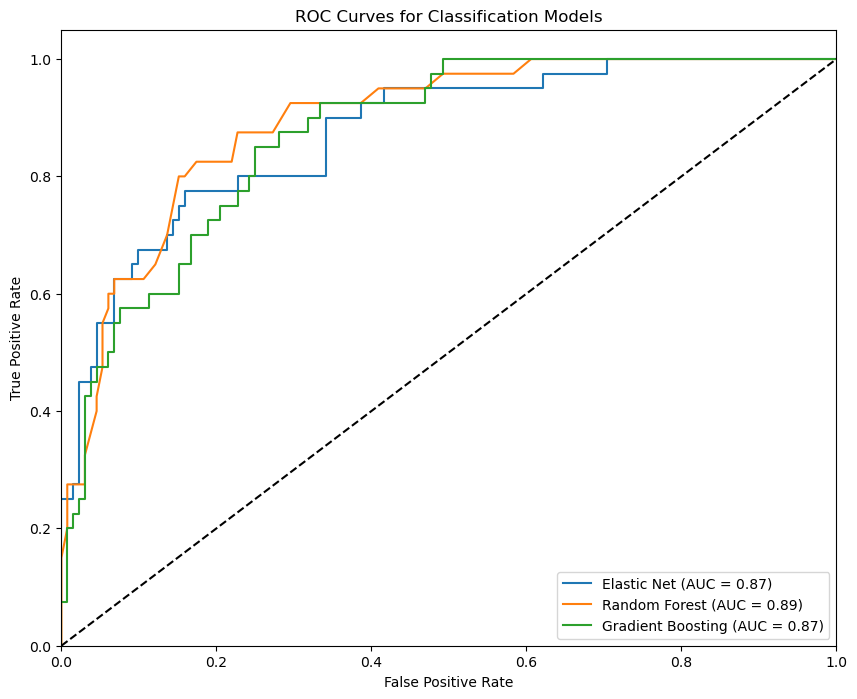


Results for differentially expressed genes:

Elastic Net:
AUC: 0.874

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       132
           1       0.74      0.62      0.68        40

    accuracy                           0.86       172
   macro avg       0.81      0.78      0.79       172
weighted avg       0.86      0.86      0.86       172


Confusion Matrix:
[[123   9]
 [ 15  25]]

Random Forest:
AUC: 0.893

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       132
           1       0.74      0.50      0.60        40

    accuracy                           0.84       172
   macro avg       0.80      0.72      0.75       172
weighted avg       0.83      0.84      0.83       172


Confusion Matrix:
[[125   7]
 [ 20  20]]

Gradient Boosting:
AUC: 0.872

Classification Report:
              precision    recall  f1-score   support

       

In [159]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

baby = None

# Data Preprocessing Function
def preprocess_data(X, y, task='classification'):
    # Encode categorical labels
    if task == 'classification':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Model Training & Evaluation Function for Classification
def train_evaluate_classification_models(X_train, X_test, y_train, y_test):
    global baby
    models = {
        'Elastic Net': LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=0.5, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        
        # Store results
        results[name] = {
            'AUC': roc_auc,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }

        if name == 'Elastic Net':
            baby = model
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Classification Models')
    plt.legend(loc="lower right")
    plt.show()
    
    return results

# Main execution
def main():
    # # For top 2% expressed genes
    print("Training models on top 2% expressed genes:")
    
    # Classification
    X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
        filtered_df_tp2_percent, softLabel_metadata['HRD_status_base'], task='classification'
    )
    
    results_top = train_evaluate_classification_models(
        X_train_top, X_test_top, y_train_top, y_test_top
    )
    
    # # ALL genes
    # print("\nTraining models on ALL genes:")
    
    # X_train_all, X_test_all, y_train_all, y_test_all = preprocess_data(
    #     gene_expression_int, softLabel_metadata['HRD_status_base'], task='classification'
    # )
    
    # results_de = train_evaluate_classification_models(
    #     X_train_all, X_test_all, y_train_all, y_test_all
    # )
    
    # # Print results
    # print("\nResults for top 2% expressed genes:")
    # for model_name, metrics in results_top.items():
    #     print(f"\n{model_name}:")
    #     print(f"AUC: {metrics['AUC']:.3f}")
    #     print("\nClassification Report:")
    #     print(metrics['Classification Report'])
    #     print("\nConfusion Matrix:")
    #     print(metrics['Confusion Matrix'])
    
    print("\nResults for differentially expressed genes:")
    for model_name, metrics in results_top.items():
        print(f"\n{model_name}:")
        print(f"AUC: {metrics['AUC']:.3f}")
        print("\nClassification Report:")
        print(metrics['Classification Report'])
        print("\nConfusion Matrix:")
        print(metrics['Confusion Matrix'])

# For regression task on Confidence values
def train_evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'R2': r2,
            'Model': model
        }
        
        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Confidence')
        plt.ylabel('Predicted Confidence')
        plt.title(f'{name} - Actual vs Predicted')
        plt.show()
    
    return results

# # Run regression models
# def run_regression():
#     print("\nTraining regression models for Confidence prediction:")
    
#     # For top 2% expressed genes
#     X_train_top, X_test_top, y_train_top, y_test_top = preprocess_data(
#         rnaseq_df_top_genes, brca_df_common['Confidence'], task='regression'
#     )
    
#     results_top_reg = train_evaluate_regression_models(
#         X_train_top, X_test_top, y_train_top, y_test_top
#     )
    
#     print("\nRegression Results for top 2% expressed genes:")
#     for model_name, metrics in results_top_reg.items():
#         print(f"\n{model_name}:")
#         print(f"MSE: {metrics['MSE']:.6f}")
#         print(f"R2: {metrics['R2']:.3f}")

googoog = main()
#run_regression()